In [451]:
import pandas as pd
import pandas_gbq as bq
import numpy as np
import warnings
from numpy.random import choice
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time 
import statsmodels.api as sm
import imblearn

warnings.filterwarnings('ignore')

Part 1: Data Exploration and Evaluation

For this project, please use the following columns:

‘loan_amnt’, ‘funded_amnt’, ‘term’, ‘int_rate’, ‘grade’, ‘annual_inc’, ‘issue_d’, ‘dti’, ‘revol_bal’, ‘total_pymnt’, ‘loan_status’

Load the data, select the relevant columns, and perform any necessary cleaning and aggregations to explore and better understand the dataset. Describe any assumptions you made to handle null variables and outliers. Describe the distributions of the features. Include two data visualizations and two summary statistics to support these findings.

In [452]:
loan_raw = pd.read_csv('loan.csv')

In [453]:
loan = loan_raw[['loan_amnt', 'funded_amnt', 'term', 'int_rate', 'grade', 'annual_inc', 'issue_d', 'dti', 'revol_bal', 'total_pymnt', 'loan_status']]

print(f'Number of rows {loan.shape[0]} | number of columns {loan.shape[1]}')

Number of rows 887379 | number of columns 11


In [454]:
missing = pd.DataFrame(loan.isnull().sum())
missing['pct'] = missing[0]/len(loan) * 100
missing.columns = ['count', 'pct']

missing

,count,pct
loan_amnt,0,0.000000
funded_amnt,0,0.000000
term,0,0.000000
int_rate,0,0.000000
grade,0,0.000000
annual_inc,4,0.000451
issue_d,0,0.000000
dti,0,0.000000
revol_bal,0,0.000000
total_pymnt,0,0.000000


In [455]:
loan[loan['annual_inc'].isnull()]

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,dti,revol_bal,total_pymnt,loan_status
42449,5000.0,5000.0,36 months,7.43,A,NaN,Aug-2007,1.0,0.0,5593.46,Does not meet the credit policy. Status:Fully ...
42450,7000.0,7000.0,36 months,7.75,A,NaN,Aug-2007,1.0,0.0,7867.53,Does not meet the credit policy. Status:Fully ...
42480,6700.0,6700.0,36 months,7.75,A,NaN,Jul-2007,1.0,0.0,7530.42,Does not meet the credit policy. Status:Fully ...
42533,6500.0,6500.0,36 months,8.38,A,NaN,Jun-2007,4.0,0.0,7373.83,Does not meet the credit policy. Status:Fully ...


In [456]:
loan = loan[np.isfinite(loan['annual_inc'])]

We are only missing values from the annual income field of the data set. If the percentage of missing values for this data was larger, we could have imputed the missing values. As all the missing income values were for grade A loans, we could have imputed the income values with the mean or median income of other grade A loans. More generally, a KNN based method could also be used. In any case, the missing data values account for only 0.00045% of the data and can be safely removed from the data set. 

In [457]:
datatypes = {}
for i, j in loan.dtypes.items():
    if j not in datatypes:
        datatypes[j] = [i]
    else:
        datatypes[j].append(i)

In [458]:
floats = datatypes[list(datatypes.keys())[0]]
objects = datatypes[list(datatypes.keys())[1]]

print(f'{len(floats)} columns are floats and {len(objects)} are objects')

7 columns are floats and 4 are objects


In order to understand the distribution of continous variables, we will explore descriptive statistics such as median and mean and examine the histograms of each feature

In [459]:
for i in floats:
    print(loan[i].describe())

count    887375.000000
mean      14755.302719
std        8435.455353
min         500.000000
25%        8000.000000
50%       13000.000000
75%       20000.000000
max       35000.000000
Name: loan_amnt, dtype: float64
count    887375.000000
mean      14741.915678
std        8429.897443
min         500.000000
25%        8000.000000
50%       13000.000000
75%       20000.000000
max       35000.000000
Name: funded_amnt, dtype: float64
count    887375.000000
mean         13.246764
std           4.381862
min           5.320000
25%           9.990000
50%          12.990000
75%          16.200000
max          28.990000
Name: int_rate, dtype: float64
count    8.873750e+05
mean     7.502759e+04
std      6.469830e+04
min      0.000000e+00
25%      4.500000e+04
50%      6.500000e+04
75%      9.000000e+04
max      9.500000e+06
Name: annual_inc, dtype: float64
count    887375.000000
mean         18.157113
std          17.190629
min           0.000000
25%          11.910000
50%          17.650000
75% 

In [460]:
def list_subplot(rows, columns):
    plts = []
    for i in range(rows):
        for j in range(columns):
            plts.append((i, j))
    return plts

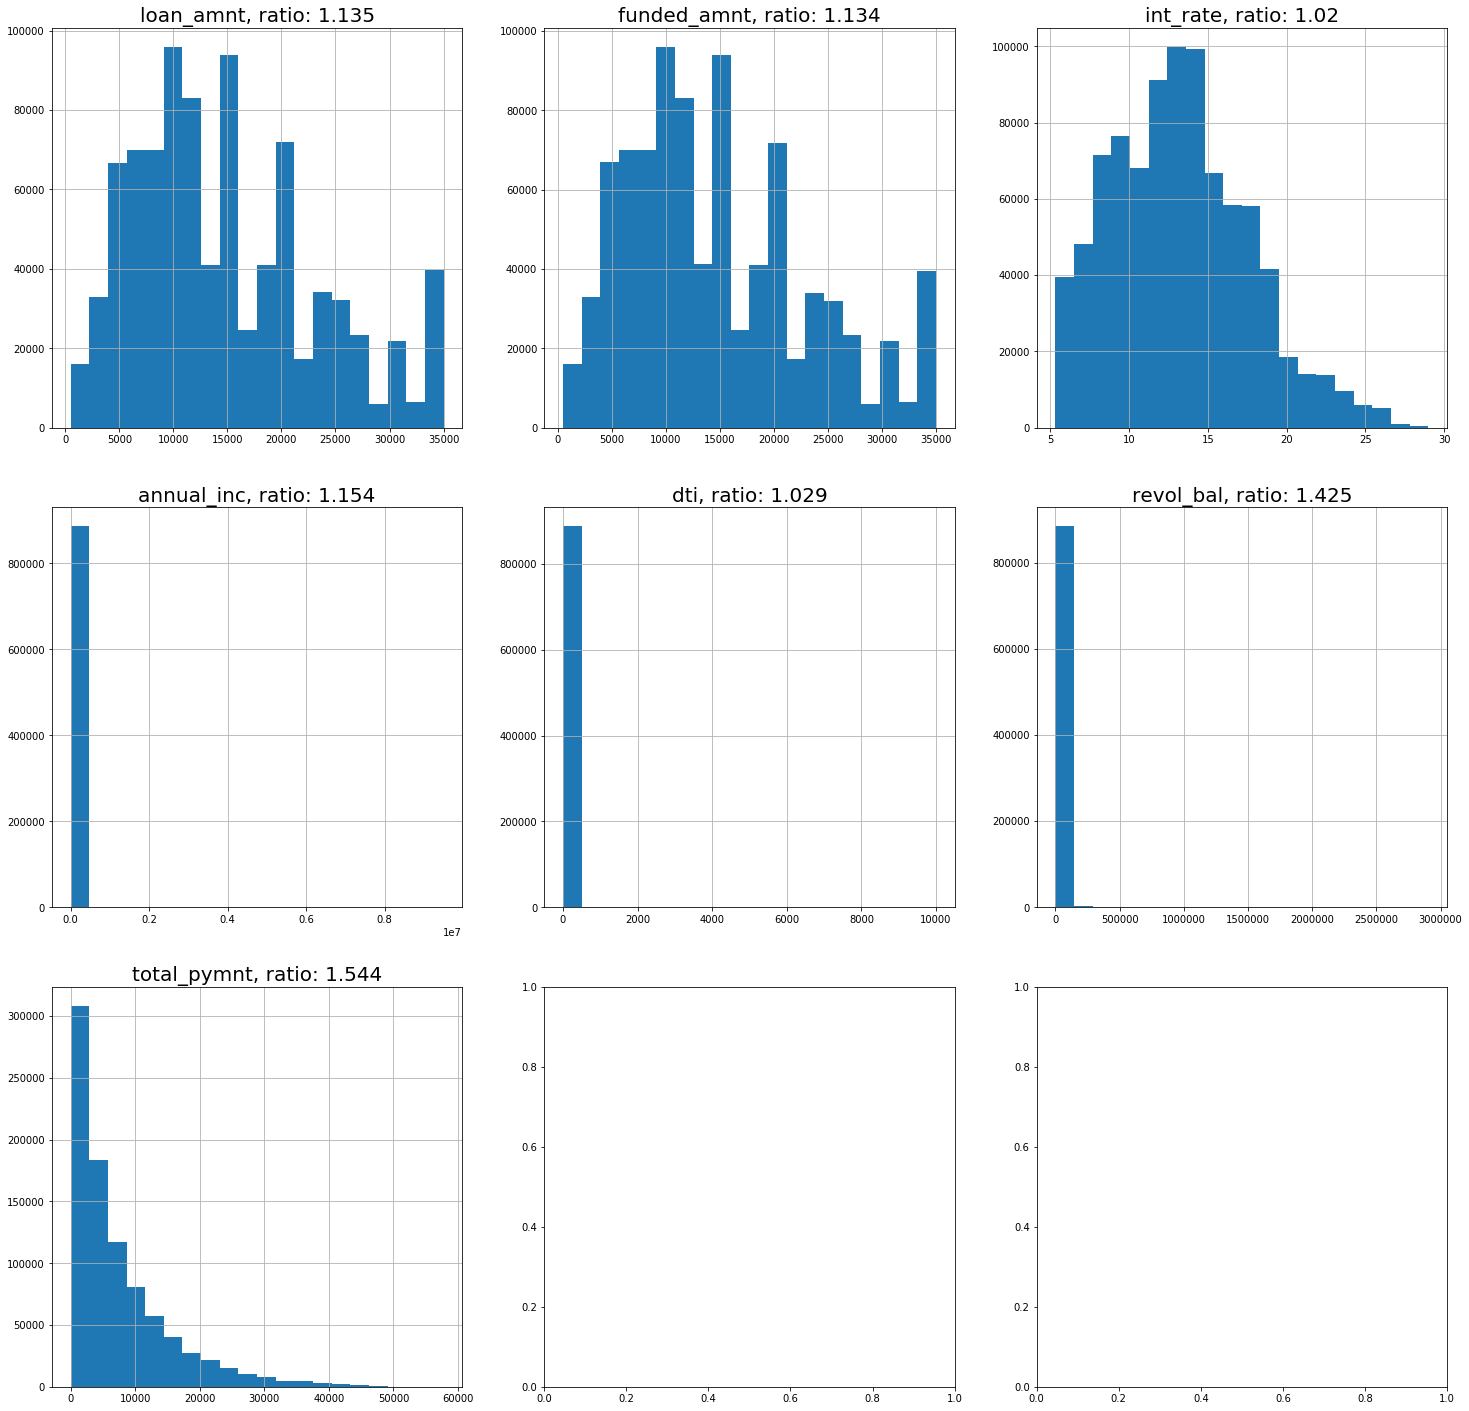

In [461]:
f, axes = plt.subplots(3, 3)
f.set_size_inches(25, 25)
for i, j in zip(floats, list_subplot(3, 3)):
    subset = loan[i]
    mean_med_rat = round(np.mean(subset)/np.median(subset), 3)
    hists = subset.hist(bins = 20, ax = axes[j[0]][j[1]])
    hists.set_title(f'{i}, ratio: {mean_med_rat}', fontsize = 20)

From the histograms and descriptive statistics, all the continuous features display some right skew. However, for loan_amnt, funded_amnt, int_rate, annual_inc, and dti, the median and mean values are relatively similar, meaning that the distribution of these features is not very skewed. However, the histograms of annual_inc and dti show extreme skew pointing to potential outliers.  On the other hand, the mean/median ratio for revol_bal and total_pymnt are between 1.4 and 1.55. Revol_bal shows a higher skew on the histogram than total_pymnt and almost no data in the right tail indicating there might be some outliers even though revol_bal is most likely a heavily skewed dsitribution anyway. 

Since we suspect that dti and annual_inc are relatively well centered around the mean, a z-score cutoff of 3 will be used to identify extreme values. Since revol_bal is most likely a skewed a distribution, z-score cutoffs between 3 and 5 will be tested to make sure that not too much data is being removed and the underlying distribution is not changed. 

In [462]:
def get_cutoff(var, stds = 3):
    std = np.std(loan[var])
    var_mean = np.mean(loan[var])
    upper = var_mean + stds * std
    print(f'{len(loan[loan[var] > upper])/len(loan) * 100}% of data are {stds} standard deviations above the mean')
    loan[loan[var] < upper][var].hist(bins = 20)
    return upper

0.0022538385688125086% of data are 3 standard deviations above the mean


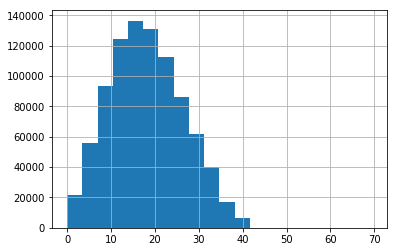

In [463]:
upper_dti = get_cutoff('dti')

0.79819692914495% of data are 3 standard deviations above the mean


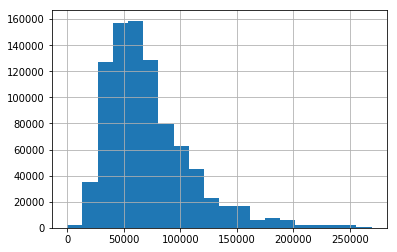

In [464]:
upper_inc = get_cutoff('annual_inc')

0.7767854627412312% of data are 4 standard deviations above the mean


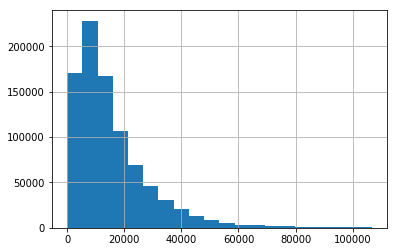

In [465]:
upper_rb = get_cutoff('revol_bal', 4)

In [468]:
new_loan = loan[(loan['dti'] <= upper_dti) & (loan['annual_inc'] <= upper_inc) & (loan['revol_bal'] <= upper_rb)]

In [469]:
len(new_loan)/len(loan)

0.9855044372446824

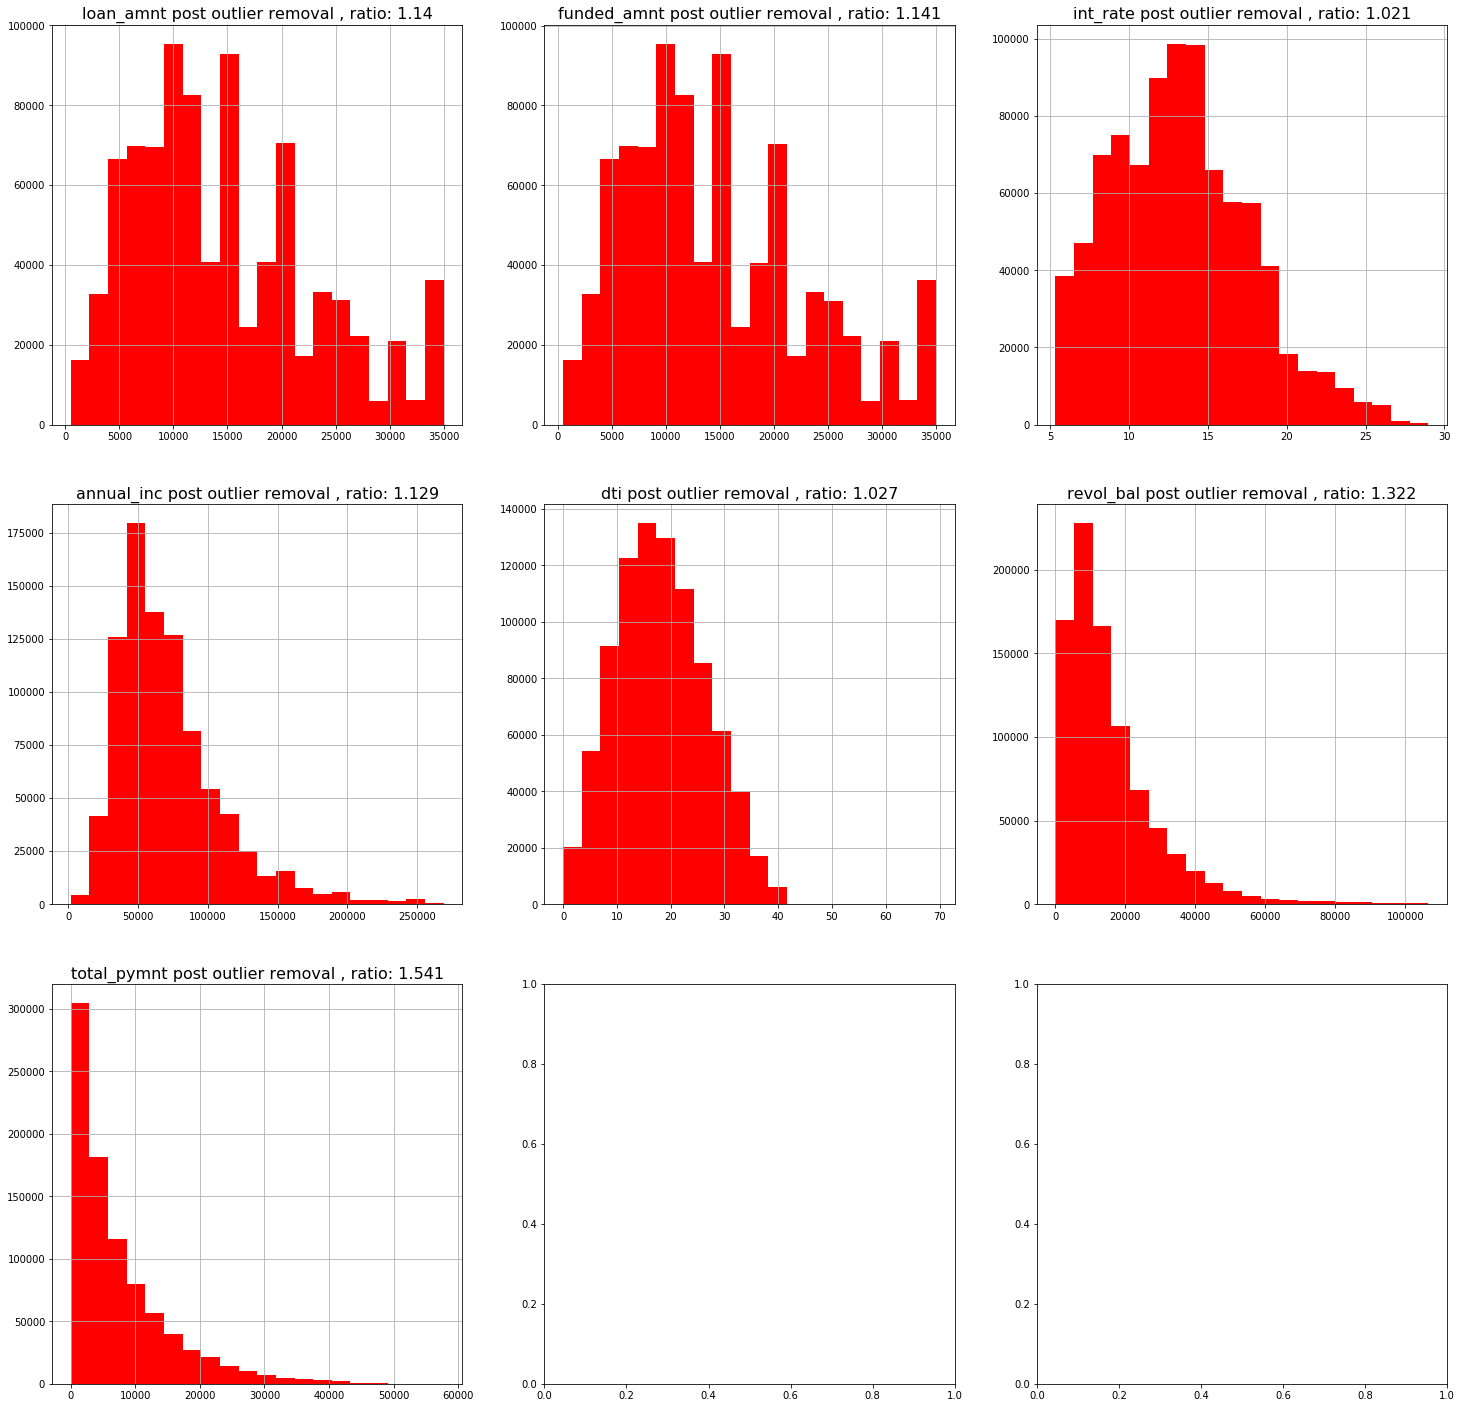

In [470]:
f, axes = plt.subplots(3, 3)
f.set_size_inches(25, 25)
for i, j in zip(floats, list_subplot(3, 3)):
    subset = new_loan[i]
    mean_med_rat = round(np.mean(subset)/np.median(subset), 3)
    hists = subset.hist(bins = 20, color = 'r', ax = axes[j[0]][j[1]])
    hists.set_title(f'{i} post outlier removal , ratio: {mean_med_rat}', fontsize = 16)

By removing outlying values 3 standard deviations away from dti, we see that dti has a close to normal distribution. As suspected, revol_bal does have a heavy right tail and annual_inc is somewhat positively skewed. After removing outlying values, 98.6% of the data was preserved and the distributions of total_pymnt, loan_amnt, funded_amnt, and int_rate remained largely unchanged. From the histograms, it is clear that the distribution of loan_amnt and funded amnt are almost identical, as expected, which indicates multicollinearity would arise if both features were included in a prediction model

Of the four categorical features, issue_d is actually a timestamp and will be treated accordingly

In [427]:
#transforming issue_d to datetime from string
loan['issue_dt'] = loan['issue_d'].apply(lambda x: datetime.strptime(x, '%b-%Y'))
loan['issue_yr'] = loan['issue_dt'].apply(lambda x: x.year)
loan['issue_mon'] = loan['issue_dt'].apply(lambda x: x.month)

In [428]:
objects.append('issue_yr')
objects.append('issue_mon')
objects.append('issue_dt')
objects.remove('issue_d')

In [429]:
objects

['term', 'grade', 'loan_status', 'issue_yr', 'issue_mon', 'issue_dt']

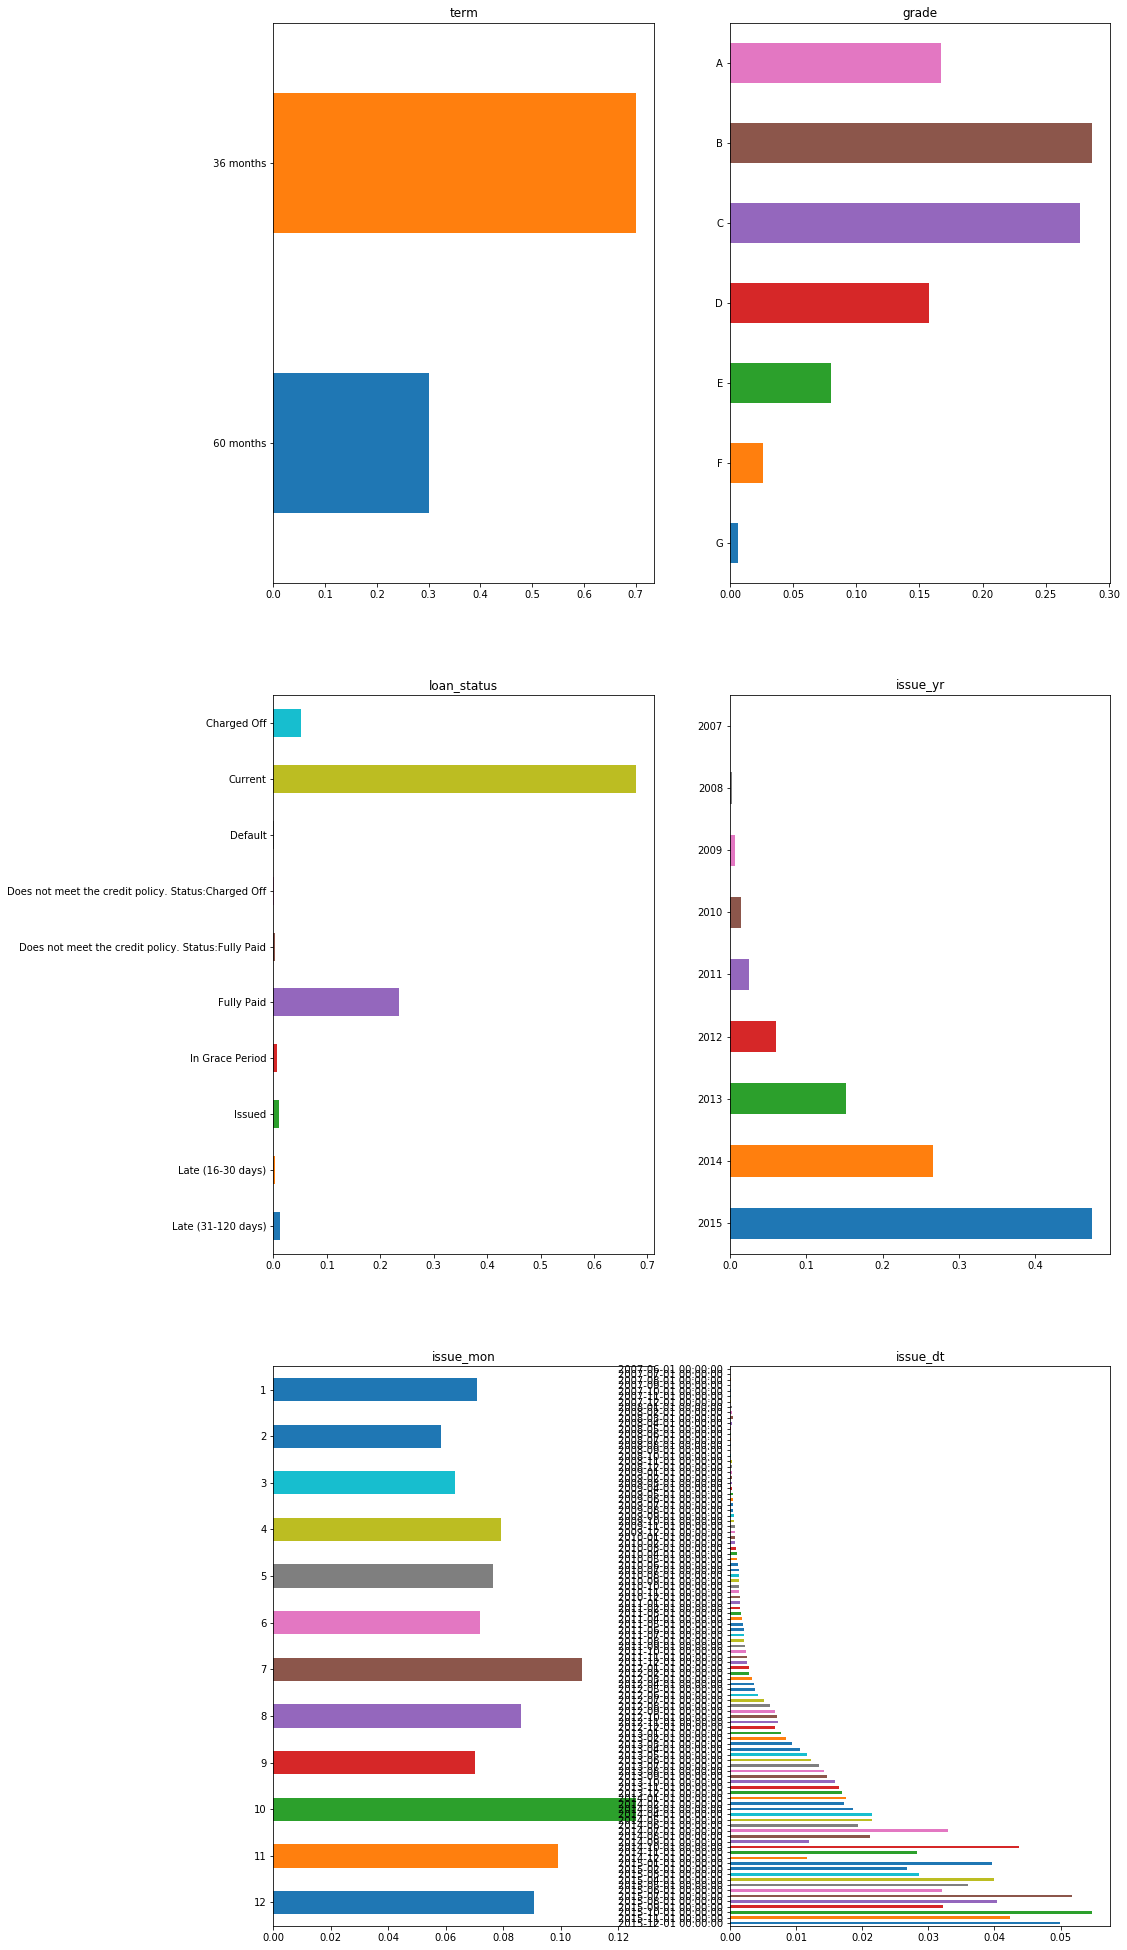

In [430]:
f, axes = plt.subplots(3, 2)
f.set_size_inches(15, 35)
for i, j in zip(objects, list_subplot(3, 2)):
    loan[i].value_counts(normalize=True).sort_index(ascending = False).plot(kind = 'barh', title = i,ax = axes[j[0]][j[1]] )

Issue_d was parsed into issue_yr and issue_mon for further granularity. Looking at the normalized counts for issue_yr and issue_dt (month year) show that the number of loans issued has mostly increased over time. The number of loans issued does not vary as regularly across months of year. The highest number of bonds was issued in October. 

The majority of the loans issued are of grades B and C, 28.7 and 27.7% respectively. Only ~11% of loans issued were below grade D. The majority of loans are either current or fully paid. Only considering loans where the end status is known, ~73% are full paid. 70% of loans are of a 36 month term length.

Part 2

We are interested in evaluating whether the 36 month term loans would make for a good investment. Please investigate the following. Assume a 36 month investment period for each loan, and exclude loans with less than 36 months of data available.

1) What percentage of loans has been fully paid? 83.9%

2) When bucketed by year of origination and grade, which cohort has the highest rate of defaults? Here you may assume that any loan which was not fully paid had “defaulted”. 2007, grade G

3) When bucketed by year of origination and grade, what annualized rate of return have these loans generated on average? 0.51%

For simplicity, use the following approximation: Annualized rate of return = (total_pymnt / funded_amnt) ^ (1/3) - 1

In order to answer the questions above, the following data preparation steps were taken

1. remove 4 rows with null values 
2. parse out year and month from issue_d
3. create a binary column for default or non-default
4. approximate annualized rate of return and store in column 'arr'
5. create a new column delta_m to find out how many months of data is present for each loan where the end date ie 9/2015

In [473]:
loan = loan[np.isfinite(loan['annual_inc'])]

loan['issue_dt'] = loan['issue_d'].apply(lambda x: datetime.strptime(x, '%b-%Y'))
loan['issue_yr'] = loan['issue_dt'].apply(lambda x: x.year)
loan['issue_mon'] = loan['issue_dt'].apply(lambda x: x.month)
loan['term_length'] = loan['term'].apply(lambda x: int(x.split(' ')[1]))
loan['default'] = np.where(loan['loan_status']=='Fully Paid', 0, 1)
loan['arr'] = (loan['total_pymnt']/loan['funded_amnt']) ** (1/3) - 1
loan['delta_m'] = (2015 - loan['issue_yr'] ) * 12 + (9 - loan['issue_mon'] )

In [475]:
loan_36  = loan[(loan['term_length'] == 36) & (loan['delta_m'] >= 36)]
print(loan_36.shape)
loan.head()

(59819, 18)


,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,dti,revol_bal,total_pymnt,loan_status,issue_dt,issue_yr,issue_mon,term_length,default,arr,delta_m
0,5000.0,5000.0,36 months,10.65,B,24000.0,Dec-2011,27.65,13648.0,5861.071414,Fully Paid,2011-12-01,2011,12,36,0,0.054393,45
1,2500.0,2500.0,60 months,15.27,C,30000.0,Dec-2011,1.00,1687.0,1008.710000,Charged Off,2011-12-01,2011,12,60,1,-0.261061,45
2,2400.0,2400.0,36 months,15.96,C,12252.0,Dec-2011,8.72,2956.0,3003.653644,Fully Paid,2011-12-01,2011,12,36,0,0.077654,45
3,10000.0,10000.0,36 months,13.49,C,49200.0,Dec-2011,20.00,5598.0,12226.302212,Fully Paid,2011-12-01,2011,12,36,0,0.069297,45
4,3000.0,3000.0,60 months,12.69,B,80000.0,Dec-2011,17.94,27783.0,3242.170000,Current,2011-12-01,2011,12,60,1,0.026215,45


In [476]:
#1) What percentage of loans has been fully paid?

loan_36.loan_status.value_counts(normalize=True).sort_values(ascending = False)

Fully Paid                                             0.839215
Charged Off                                            0.120045
Does not meet the credit policy. Status:Fully Paid     0.029840
Does not meet the credit policy. Status:Charged Off    0.010849
Late (31-120 days)                                     0.000033
Default                                                0.000017
Name: loan_status, dtype: float64

In [477]:
#2 When bucketed by year of origination and grade, which cohort has the highest rate of defaults? 
#Here you may assume that any loan which was not fully paid had “defaulted”.
yr_grade = loan_36.groupby(['issue_yr','grade'])['default', 'arr'].mean()
yr_grade.reset_index(inplace=True)
yr_grade.sort_values('default', ascending = False).head()

,issue_yr,grade,default,arr
6,2007,G,1.000000,-0.044102
13,2008,G,0.976744,-0.007913
4,2007,E,0.910000,-0.015099
5,2007,F,0.903846,-0.079863
12,2008,F,0.900901,-0.045138


In [478]:
#3) When bucketed by year of origination and grade, what annualized rate of return have these loans generated on average?
np.mean(yr_grade['arr']) * 100

0.5099262224790543

Please build a logistic regression model to predict loan defaults (as defined in question 2 above) that could help us avoid investing in such loans. Assume that (i) you are given the ability to invest in each loan independently; (ii) you invest immediately following loan origination and hold to maturity (36 months); and (iii) all loan fields that would be known upon origination are made available to you.

Was the model effective? Explain how you validated your model and describe how you measure the performance of the model.

Many real world classification problems suffer from the problem of imbalanced classes in which one outcome is observed much more frequently than the other. In the event of imbalanced classed, classifiers such as Logistic Regression can sometimes fail to classify the minority class and instead classifies it as noise in the model. Therefore, in event prediction for fraud and default, accuracy cannot be the only metric used to measure a classifiers performance. As an extreme example, if a loan defaults 5% of the time and the classifier classifies all examples to have a non-default outcome, the classifier will have achieved 95% accuracy. In such cases, we look for other metrics that can explain how well a model is able to separate 2 classes. The receiver operator curve (ROC) is a probability curve that plots true postive rate against false positive rate for all possible probability cutoffs (point at which a point is classified as a positive or negative example). The area under the curve (AUC) is the area under the ROC that determines how well a model can distinguish between classes. For our specific problem of loan default, I have chosen to evaluate the model on miss rate, sensitivity, AUC. Model validation was performed by holding out 30% of the data for testing and using 70% for training. 

Miss rate = FN/(FN + TP)
Sensitivity = TP/(TP + FN)

When deciding to issue a loan, the outcome of issuing a loan to a customer at high risk of degault is higher than not issuing a loan. Therefore, the lower miss rate or false negative rate of the model the better the model performs. 

In order to solve account for imbalanced classes I ran three variations of a logistic regression model. 
1. Plain Logistic regression
2. SMOTE oversampling on the training data - Synthetic Minority Oversampling Technique (SMOTE) is a technique that creates synthetic observations of the minority class by randomly sampling from the K-nearest neighbors of the minority class and creating a similar synthetic example. In this manner, SMOTE aims to correct for the risk of overfitting by randomly oversampling the minority class while also preventing information loss by undersampling the majority class. 
*Oversampling is only performed on the training set so no information is leaked to the test set. 
3. Logistic regression with balanced class weights - Sklearn has a parameter called clas_weight to penalize misclassifciations in smaples of class[i] with class_weight[i] by adjusting the regularization parameter. Therefore, classes with a higher class weight receive more emphasis. the 'balanced' paramter calculates the class weights as the inverse of the frequency in which the classes occur.


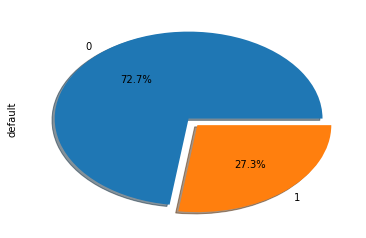

In [436]:
loan_predict['default'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',shadow=True)

In [480]:
#remove variables not known upon origination, total_pymnt, loan_status and outlies and loans which are Current 
#since we have no way of knowing the outcome of such laosn
loan = loan[loan['loan_status'] != 'Current']
loan = loan[(loan['dti'] <= upper_dti) & (loan['annual_inc'] <= upper_inc) & (loan['revol_bal'] <= upper_rb)]
loan_predict = loan[['loan_amnt', 'funded_amnt', 'revol_bal', 'term_length','int_rate','grade','annual_inc', 
                      'issue_yr', 'issue_mon', 'dti', 'default']]

loan_predict = loan_predict.sort_values('grade', ascending = False)
loan_predict['grade_num']= pd.factorize(loan_predict['grade'])[0]

del loan_predict['grade']

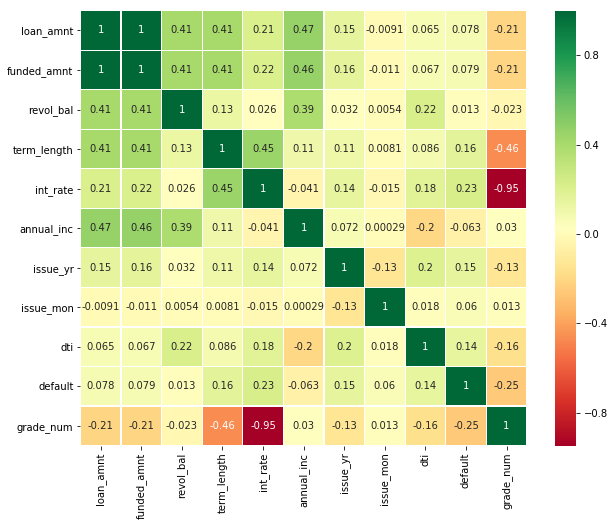

In [481]:
sns.heatmap(loan_predict.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) 
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

The correlation matrix shows that loan_amnt and funded_amnt are highly positively correlated while int_rate and grade are negatively correlated. In order to avoid multicollinearity concerns, wben fitting the model the model will be tried with and without the correlated predictors

In [482]:
#turn non-ordinal categorical variables into dummies (issue_yr, issue_month, term_length)
#factorize ordinal categorical variables (grade)
loan_predict = pd.concat([loan_predict, pd.get_dummies(loan_predict['issue_yr'])], axis=1)
loan_predict = pd.concat([loan_predict, pd.get_dummies(loan_predict['issue_mon'])], axis=1)
loan_predict = pd.concat([loan_predict, pd.get_dummies(loan_predict['term_length'])], axis=1)

del loan_predict['issue_yr']
del loan_predict['issue_mon']
del loan_predict['term_length']
del loan_predict[60]
del loan_predict[2008]
del loan_predict[2]

In [483]:
loan_predict.head()

,loan_amnt,funded_amnt,revol_bal,int_rate,annual_inc,dti,default,grade_num,2007,2009,...,4,5,6,7,8,9,10,11,12,36
143721,22000.0,22000.0,15022.0,24.89,67300.0,34.69,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4422,12850.0,12850.0,686.0,22.74,60000.0,1.36,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
284441,10725.0,10725.0,7774.0,25.80,36100.0,25.13,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
390845,3750.0,3750.0,10075.0,25.80,50000.0,24.27,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
390822,16475.0,16475.0,7678.0,25.80,55000.0,18.36,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [484]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score, confusion_matrix,accuracy_score, roc_curve, precision_recall_curve, f1_score
from imblearn.over_sampling import SMOTE

predictors = [i for i in loan_predict.columns if i not in ['default', 'funded_amnt', 'int_rate']]
train,test=train_test_split(loan_predict,test_size=0.3,random_state=0,stratify=loan_predict['default'])
train_X = train[predictors]
train_Y = train['default']
test_X = test[predictors]
test_Y = test['default']
X = loan_predict[predictors]
Y = loan_predict['default']

smote = SMOTE(ratio='minority')
trainx_sm, trainy_sm = smote.fit_sample(train_X, train_Y)

In [485]:
def model_eval(model_name, trainx, trainy, balanced = False):
    if balanced:
        model = LogisticRegression(class_weight='balanced')
    else:
        model = LogisticRegression()
    model.fit(trainx,trainy)
    prediction=model.predict(test_X)
    model_probs = model.predict_proba(test_X)[:, 1:]
    model_auc_score = roc_auc_score(test_Y, model_probs)
    fpr, tpr, _ = roc_curve(test_Y, model_probs)
    plt.plot(fpr, tpr, label=f'auc = {model_auc_score:.3f}')
    plt.plot([0,1])
    plt.legend(loc='best')
    cm = pd.crosstab(test_Y, prediction, rownames=['True'], colnames=['Predicted'], margins=True)
    TP = cm[1][1]
    FP = cm[1][0]
    TN = cm[0][0]
    FN = cm[0][1]
    miss_rate = FN/(FN + TP)
    sensitivity = TP/(TP + FN)
    
    print( f'The accuracy of the {model_name} is {metrics.accuracy_score(prediction,test_Y)}')
    print( f'The miss rate of the {model_name} is {miss_rate}')
    print( f'The sensitivity rate of the {model_name} is {sensitivity}')
    print('')
    print(pd.crosstab(test_Y, prediction, rownames=['True'], colnames=['Predicted'], margins=True))

The accuracy of the Logistic Regression is 0.7273682843004098
The miss rate of the Logistic Regression is 0.9998267498267498
The sensitivity rate of the Logistic Regression is 0.00017325017325017325

Predicted      0  1    All
True                      
0          61583  0  61583
1          23084  4  23088
All        84667  4  84671


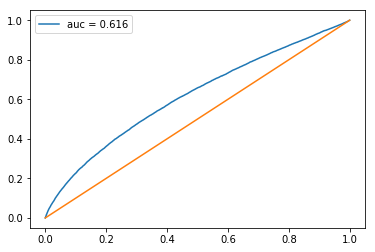

In [486]:
model_eval('Logistic Regression', train_X, train_Y)


The accuracy of the LR oversampled w/SMOTE is 0.6500336596945826
The miss rate of the LR oversampled w/SMOTE is 0.4243762993762994
The sensitivity rate of the LR oversampled w/SMOTE is 0.5756237006237006

Predicted      0      1    All
True                          
0          41749  19834  61583
1           9798  13290  23088
All        51547  33124  84671


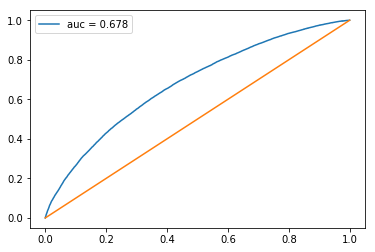

In [487]:
model_eval('LR oversampled w/SMOTE', trainx_sm, trainy_sm)

The accuracy of the LR with balanced class weights is 0.6626708081869825
The miss rate of the LR with balanced class weights is 0.4079175329175329
The sensitivity rate of the LR with balanced class weights is 0.592082467082467

Predicted      0      1    All
True                          
0          42439  19144  61583
1           9418  13670  23088
All        51857  32814  84671


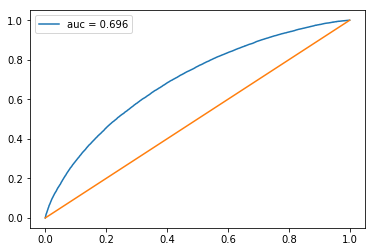

In [488]:
model_eval('LR with balanced class weights', train_X, train_Y, balanced = True)


When evaluating all three variation of logistic regression, the model using balanced class weights has the highest AUC and lowest miss rate with the model trained using SMOTE oversampling coming in second. As expected, the plain logistic regression had the highest accuracy but the lowest AUC and a miss rate of 99%. Based on the scaled coefficients from the balanced model, it appears the grade, dti, and annual_income were all important predictors. Overall, the model is somewhat successful, with a 40% miss rate and 67% accuracy. Depending on the loan strategy, the model can always be tuned for higher or lower sensitivity using different cutoff points. Additionally, the model could definitely benefit from using other types of classifiers such as Naive Bayes or tree classifiers. 

In [489]:
model = LogisticRegression(class_weight='balanced')
model.fit(train_X,train_Y)
prediction=model.predict(test_X)

In [490]:
std_coefs = np.std(train_X, 0).values * model.coef_
std_coefs = std_coefs.tolist()[0]

coefs = [i for i in zip(list(train_X.keys()), std_coefs)]
coefs.sort(key=lambda x: abs(x[1]), reverse = True)
for i, j in coefs:
    print(f'feature : {i} | coefficient: {j}')

feature : grade_num | coefficient: -0.4662916215807229
feature : 2015 | coefficient: 0.3159588881798158
feature : 12 | coefficient: 0.2792569491021778
feature : annual_inc | coefficient: -0.21197731123545546
feature : dti | coefficient: 0.17340822964605887
feature : 2014 | coefficient: 0.12604806975266777
feature : 2012 | coefficient: -0.11374676911611595
feature : loan_amnt | coefficient: 0.10513380759402308
feature : 36 | coefficient: -0.08792967993740816
feature : 2011 | coefficient: -0.07993227177545165
feature : 1 | coefficient: -0.05309638719179523
feature : 11 | coefficient: 0.036153364910804696
feature : 6 | coefficient: 0.029403428436193778
feature : 2013 | coefficient: 0.02050090312044335
feature : 10 | coefficient: 0.01986648290286134
feature : 9 | coefficient: 0.018346918543552488
feature : 2010 | coefficient: -0.01522274885406093
feature : 3 | coefficient: -0.012654417431056074
feature : 7 | coefficient: 0.009984140479302898
feature : 2007 | coefficient: 0.0064410472661011